# BI-GRU

In [1]:
import os
import pandas as pd
import numpy as np
import gensim
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow import keras
from winsound import Beep
import matplotlib.pyplot as plt
from winsound import Beep
import matplotlib.pyplot as plt
from scipy.stats import mode

In [2]:
# def read_data_from_dir(data_dir):
#     x_data = []
#     y_data = []
#     for class_dir in os.listdir(data_dir):
#         class_dir_pth = os.path.join(data_dir, class_dir)
#         print(f"working on {class_dir} ...")
#         n_files = len(os.listdir(class_dir_pth))
#         for i, document in enumerate(os.listdir(class_dir_pth)):
#             document_pth = os.path.join(class_dir_pth, document)
#             with open(document_pth, encoding="UTF-8") as f:
#                 lines = f.readlines()
#                 x_data.append(lines[1])
#                 y_data.append(class_dir)
#             print(f"{int(100 * i / n_files)} %", end='\r')
#     print("done!")
    
#     return x_data, y_data

In [3]:
# data_dir = "E:\Technical\Electro pi\SANAD_ Single-Label Arabic News Articles Dataset for Automatic Text Categorization\SANAD_SUBSET\khaleej"
# train_data_dir = os.path.join(data_dir, "Train")
# test_data_dir = os.path.join(data_dir, "Test")

# x_train, y_train = read_data_from_dir(train_data_dir)
# x_test, y_test = read_data_from_dir(test_data_dir)

In [4]:
# df_train = pd.DataFrame(x_train, columns=["text"])
# df_train["class"] = y_train
# df_train.to_csv("train_khaleej.csv", index=False)

# df_test = pd.DataFrame(x_test, columns=["text"])
# df_test["class"] = y_test
# df_test.to_csv("test_khaleej.csv", index=False)

In [5]:
df_train = pd.read_csv("train_khaleej.csv")
df_test = pd.read_csv("test_khaleej.csv")

Preprocessing

In [6]:
x_train_cleaned = map(gensim.utils.simple_preprocess, df_train.text)
x_test_cleaned = map(gensim.utils.simple_preprocess, df_test.text)

x_train_cleaned = np.array(list(x_train_cleaned), dtype=object)
x_test_cleaned = np.array(list(x_test_cleaned), dtype=object)

In [7]:
wv_model = gensim.models.Word2Vec.load("word2vec-SANAD-khaleej-arabic-language.model")

In [8]:
def text2vect(text):
    batch_size = len(text)
    text_vect = []
    for i in range(batch_size):
        n_steps = len(text[i])
        sent_vect = np.empty((n_steps, 100))
        for j, word in enumerate(text[i]):
            try:
                sent_vect[j,:] = wv_model.wv[word].astype("float32")
            except KeyError:
                sent_vect[j,:] = np.zeros(100)
        text_vect.append(sent_vect)
    return text_vect

In [9]:
x_train_cleaned_vec = text2vect(x_train_cleaned)
x_test_cleaned_vec = text2vect(x_test_cleaned)

In [11]:
x_train_cleaned_vec_pad = keras.preprocessing.sequence.pad_sequences(x_train_cleaned_vec, 350)
x_test_cleaned_vec_pad = keras.preprocessing.sequence.pad_sequences(x_test_cleaned_vec, 350)

In [12]:
x_train_cleaned_vec_pad.shape

(40950, 350, 100)

In [13]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train['class'])
y_test = encoder.transform(df_test['class'])

In [15]:
idx = np.arange(40950)
np.random.shuffle(idx)

x_train = x_train_cleaned_vec_pad[idx]
y_train = y_train[idx]

x_val, y_val = x_train[:5000], y_train[:5000]
x_train, y_train = x_train[5000:], y_train[5000:]

# Training

In [27]:
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
#         self.restore_best_weights = restore_best_weights
#         self.mode = mode
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0

    def on_epoch_end(self, epoch, logs=None):
        diff = logs["accuracy"] - logs["val_accuracy"]
        current = logs["val_accuracy"]
        if diff <= 0.015:
            self.wait = 0
            if np.greater(current, self.best):
                self.best = current
                self.best_weights = self.model.get_weights() # Record the best weights if current results is better (more).
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
#                 print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: custom early stopping" % (self.stopped_epoch + 1))
    

# GRU

In [28]:
GRU = keras.models.Sequential([
    keras.layers.Dropout(0.2, input_shape= [None, 100]),
    keras.layers.GRU(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation= "softmax")
])

In [29]:
patience = 3
default_early_stopping_cb = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=patience, monitor="val_accuracy")
custom_early_stopping_cb = CustomEarlyStopping(patience=patience)
checkpoint_cb = keras.callbacks.ModelCheckpoint("sentiment_analysis_sanda_ModelCheckpoint.h5", monitor="val_accuracy", save_best_only=True, )

In [30]:
GRU.compile(optimizer="adam", loss= keras.losses.sparse_categorical_crossentropy, metrics="accuracy")
history = GRU.fit(x_train, y_train, epochs=2000, validation_data= (x_val, y_val),callbacks=[checkpoint_cb, custom_early_stopping_cb], workers=8, use_multiprocessing=True, batch_size= 750)
Beep(2500, 1000)

Epoch 1/2000
48/48 [==============================] - 211s 4s/step - loss: 1.3513 - accuracy: 0.5066 - val_loss: 0.8867 - val_accuracy: 0.6790
Epoch 2/2000
48/48 [==============================] - 200s 4s/step - loss: 0.6912 - accuracy: 0.7486 - val_loss: 0.4507 - val_accuracy: 0.8478
Epoch 3/2000
48/48 [==============================] - 212s 4s/step - loss: 0.3887 - accuracy: 0.8711 - val_loss: 0.2678 - val_accuracy: 0.9218
Epoch 4/2000
48/48 [==============================] - 219s 5s/step - loss: 0.2490 - accuracy: 0.9224 - val_loss: 0.2001 - val_accuracy: 0.9442
Epoch 5/2000
48/48 [==============================] - 220s 5s/step - loss: 0.1915 - accuracy: 0.9419 - val_loss: 0.1767 - val_accuracy: 0.9498
Epoch 6/2000
48/48 [==============================] - 221s 5s/step - loss: 0.1664 - accuracy: 0.9503 - val_loss: 0.1618 - val_accuracy: 0.9534
Epoch 7/2000
48/48 [==============================] - 217s 5s/step - loss: 0.1476 - accuracy: 0.9562 - val_loss: 0.1506 - val_accuracy: 0.9558

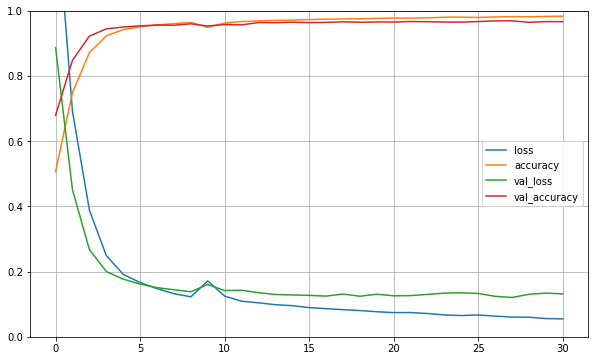

In [31]:
model_history = pd.DataFrame(history.history)
model_history.plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [32]:
GRU.evaluate(x_val, y_val)

157/157 [==============================] - 12s 76ms/step - loss: 0.1205 - accuracy: 0.9688


[0.12053944170475006, 0.9688000082969666]

In [33]:
GRU.evaluate(x_train, y_train)

1124/1124 [==============================] - 120s 107ms/step - loss: 0.0396 - accuracy: 0.9884


[0.03960761800408363, 0.9883727431297302]

In [34]:
0.9688000082969666 - (0.9883727431297302 - 0.9688000082969666) / 2 # the minimum expected val_test

0.9590136408805847

In [37]:
GRU.save("sentiment_analysis_sanda_GRU_Model.h5")

In [38]:
GRU.evaluate(x_test_cleaned_vec_pad, y_test) # the minimum expected val_test

143/143 [==============================] - 11s 76ms/step - loss: 0.1127 - accuracy: 0.9666


[0.112673819065094, 0.9665933847427368]

# LSTM

In [39]:
LSTM = keras.models.Sequential([
    keras.layers.Dropout(0.2, input_shape= [None, 100]),
    keras.layers.LSTM(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation= "softmax")
])

In [44]:
LSTM.compile(optimizer="adam", loss= keras.losses.sparse_categorical_crossentropy, metrics="accuracy")
history = LSTM.fit(x_train, y_train, epochs=2000, validation_data= (x_val, y_val),callbacks=[checkpoint_cb, custom_early_stopping_cb
                                                                                            ], workers=8, use_multiprocessing=True, batch_size= 750)
Beep(2500, 1000)

Epoch 1/2000
48/48 [==============================] - 301s 6s/step - loss: 0.2512 - accuracy: 0.9254 - val_loss: 0.2277 - val_accuracy: 0.9316
Epoch 2/2000
48/48 [==============================] - 382s 8s/step - loss: 0.2113 - accuracy: 0.9368 - val_loss: 0.2028 - val_accuracy: 0.9414
Epoch 3/2000
48/48 [==============================] - 389s 8s/step - loss: 0.1912 - accuracy: 0.9408 - val_loss: 0.1898 - val_accuracy: 0.9428
Epoch 4/2000
48/48 [==============================] - 348s 7s/step - loss: 0.1964 - accuracy: 0.9419 - val_loss: 0.2111 - val_accuracy: 0.9322
Epoch 5/2000
48/48 [==============================] - 348s 7s/step - loss: 0.1891 - accuracy: 0.9423 - val_loss: 0.1773 - val_accuracy: 0.9498
Epoch 6/2000
48/48 [==============================] - 348s 7s/step - loss: 0.1699 - accuracy: 0.9487 - val_loss: 0.1710 - val_accuracy: 0.9522
Epoch 7/2000
48/48 [==============================] - 345s 7s/step - loss: 0.1608 - accuracy: 0.9524 - val_loss: 0.1729 - val_accuracy: 0.9510

KeyboardInterrupt: 

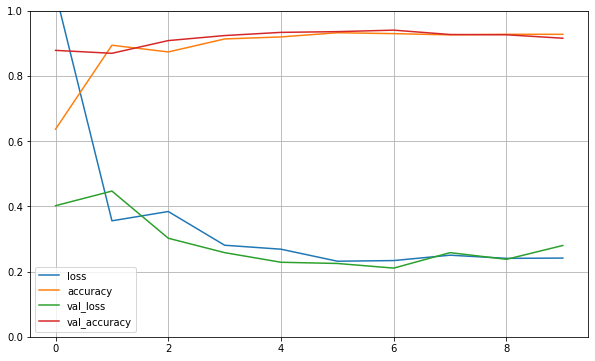

In [41]:
model_history = pd.DataFrame(history.history)
model_history.plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [45]:
LSTM.evaluate(x_val, y_val)

157/157 [==============================] - 28s 177ms/step - loss: 0.1398 - accuracy: 0.9596s - loss: 0 - ETA: 0s - loss: 0.1405 - accuracy: 


[0.139816552400589, 0.9595999717712402]

In [46]:
LSTM.evaluate(x_train, y_train)

1124/1124 [==============================] - 207s 184ms/step - loss: 0.1012 - accuracy: 0.9697


[0.10119414329528809, 0.9697357416152954]

In [47]:
0.9595999717712402 - (0.9697357416152954 - 0.9595999717712402) / 2

0.9545320868492126

In [48]:
LSTM.save("sentiment_analysis_sanda_LSTM_Model.h5")

In [49]:
LSTM.evaluate(x_test_cleaned_vec_pad, y_test)

143/143 [==============================] - 17s 116ms/step - loss: 0.1369 - accuracy: 0.9593


[0.13691796362400055, 0.9593406319618225]

# BI-LSTM

In [50]:
BiLSTM = keras.models.Sequential([
    keras.layers.Dropout(0.2, input_shape= [None, 100]),
    keras.layers.Bidirectional(keras.layers.LSTM(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation= "softmax")
])

In [51]:
BiLSTM.compile(optimizer="adam", loss= keras.losses.sparse_categorical_crossentropy, metrics="accuracy")
history = BiLSTM.fit(x_train, y_train, epochs=2000, validation_data= (x_val, y_val),callbacks=[checkpoint_cb, custom_early_stopping_cb], workers=8, use_multiprocessing=True, batch_size= 750)
Beep(2500, 1000)

Epoch 1/2000
48/48 [==============================] - 766s 16s/step - loss: 1.0173 - accuracy: 0.6590 - val_loss: 0.4465 - val_accuracy: 0.8580
Epoch 2/2000
48/48 [==============================] - 855s 18s/step - loss: 0.3794 - accuracy: 0.8796 - val_loss: 0.2703 - val_accuracy: 0.9234
Epoch 3/2000
48/48 [==============================] - 873s 18s/step - loss: 0.2697 - accuracy: 0.9164 - val_loss: 0.2142 - val_accuracy: 0.9334
Epoch 4/2000
48/48 [==============================] - 896s 19s/step - loss: 0.2502 - accuracy: 0.9221 - val_loss: 0.2619 - val_accuracy: 0.9148
Epoch 5/2000
48/48 [==============================] - 915s 19s/step - loss: 0.2606 - accuracy: 0.9176 - val_loss: 0.3177 - val_accuracy: 0.8992
Epoch 6/2000
48/48 [==============================] - 924s 19s/step - loss: 0.2702 - accuracy: 0.9174 - val_loss: 0.2276 - val_accuracy: 0.9320
Epoch 7/2000
48/48 [==============================] - 934s 19s/step - loss: 0.2204 - accuracy: 0.9329 - val_loss: 0.2201 - val_accuracy:

KeyboardInterrupt: 

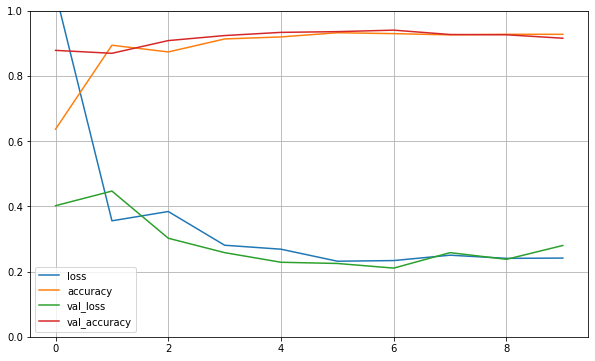

In [52]:
model_history = pd.DataFrame(history.history)
model_history.plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [53]:
BiLSTM.evaluate(x_val, y_val)

157/157 [==============================] - 67s 425ms/step - loss: 0.1513 - accuracy: 0.9600


[0.15128403902053833, 0.9599999785423279]

In [54]:
BiLSTM.evaluate(x_train, y_train)

1124/1124 [==============================] - 488s 435ms/step - loss: 0.0907 - accuracy: 0.9725


[0.09067104011774063, 0.9724617600440979]

In [55]:
0.9599999785423279 - (0.9724617600440979 - 0.9599999785423279) / 2

0.9537690877914429

In [56]:
BiLSTM.save("sentiment_analysis_sanda_BI-LSTM_Model.h5")

In [57]:
BiLSTM.evaluate(x_test_cleaned_vec_pad, y_test)

143/143 [==============================] - 49s 341ms/step - loss: 0.1365 - accuracy: 0.9598


[0.13654136657714844, 0.959780216217041]

# BI-GRU

In [58]:
BiGRU = keras.models.Sequential([
    keras.layers.Dropout(0.2, input_shape= [None, 100]),
    keras.layers.Bidirectional(keras.layers.GRU(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation= "softmax")
])

In [60]:
BiGRU.compile(optimizer="adam", loss= keras.losses.sparse_categorical_crossentropy, metrics="accuracy")
history = BiGRU.fit(x_train, y_train, epochs=2000, validation_data= (x_val, y_val),callbacks=[checkpoint_cb, custom_early_stopping_cb], workers=8, use_multiprocessing=True, batch_size= 750)
Beep(2500, 1000)

Epoch 1/2000
48/48 [==============================] - 665s 13s/step - loss: 0.1056 - accuracy: 0.9674 - val_loss: 0.1248 - val_accuracy: 0.9626
Epoch 2/2000
48/48 [==============================] - 627s 13s/step - loss: 0.0945 - accuracy: 0.9706 - val_loss: 0.1255 - val_accuracy: 0.9622
Epoch 3/2000
48/48 [==============================] - 672s 14s/step - loss: 0.0880 - accuracy: 0.9727 - val_loss: 0.1279 - val_accuracy: 0.9624
Epoch 4/2000
48/48 [==============================] - 703s 15s/step - loss: 0.0804 - accuracy: 0.9751 - val_loss: 0.1337 - val_accuracy: 0.9602
Epoch 5/2000
48/48 [==============================] - 721s 15s/step - loss: 0.0772 - accuracy: 0.9761 - val_loss: 0.1297 - val_accuracy: 0.9628
Epoch 6/2000
48/48 [==============================] - 723s 15s/step - loss: 0.0719 - accuracy: 0.9773 - val_loss: 0.1254 - val_accuracy: 0.9652
Epoch 7/2000
48/48 [==============================] - 725s 15s/step - loss: 0.0663 - accuracy: 0.9792 - val_loss: 0.1221 - val_accuracy:

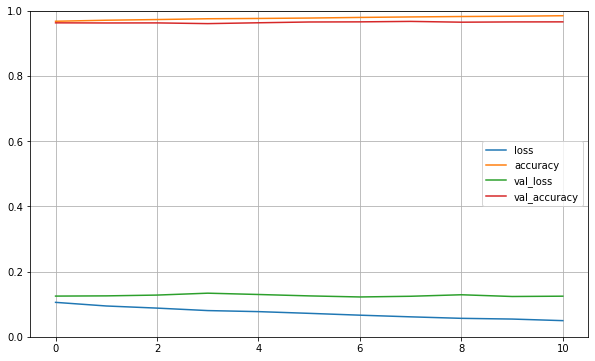

In [61]:
model_history = pd.DataFrame(history.history)
model_history.plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [62]:
BiGRU.evaluate(x_val, y_val)

157/157 [==============================] - 46s 296ms/step - loss: 0.1243 - accuracy: 0.9670


[0.12427802383899689, 0.9670000076293945]

In [63]:
BiGRU.evaluate(x_train, y_train)

1124/1124 [==============================] - 379s 337ms/step - loss: 0.0397 - accuracy: 0.9884


[0.039702530950307846, 0.9884005784988403]

In [64]:
0.9670000076293945 - (0.9884005784988403 - 0.9670000076293945) / 2

0.9562997221946716

In [65]:
BiLSTM.save("sentiment_analysis_sanda_BI-GRU_Model.h5")

In [66]:
BiLSTM.evaluate(x_test_cleaned_vec_pad, y_test)

143/143 [==============================] - 43s 304ms/step - loss: 0.1365 - accuracy: 0.9598


[0.13654136657714844, 0.959780216217041]